In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.style.use('science')
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# always import gbm_algos first !
import xgboost, lightgbm, catboost
from gplearn.genetic import SymbolicRegressor

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
from utils import *
from preprocess import *
from models import RobustPCANN

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew

from pytorch_robust_pca import *

# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder

# Tracking
from tqdm import trange

import sympy
import sympytorch

from pde_diff import *

Running Python 3.9.8
You can use npar for np.array


In [2]:
include_N_res = False

# DATA_PATH = '../deephpms_data/KS.mat'
DATA_PATH = '../PDE_FIND_experimental_datasets/kuramoto_sivishinky.mat'
X, T, Exact = space_time_grid(data_path=DATA_PATH, real_solution=True)
X_star, u_star = get_trainable_data(X, T, Exact)

# Doman bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

N = 60000 # 20000, 30000, 60000
print(f"Fine-tuning with {N} samples")
# idx = np.random.choice(X_star.shape[0], N, replace=False)
idx = np.arange(N)
X_u_train = X_star[idx, :]
u_train = u_star[idx,:]

noise_intensity = 0.01
noisy_xt = False; noisy_labels = False
if noisy_xt: X_u_train = perturb(X_u_train, noise_intensity); print("Noisy (x, t)")
else: print("Clean (x, t)")
if noisy_labels: u_train = perturb(u_train, noise_intensity); print("Noisy labels")
else: print("Clean labels")

# Unsup data
if include_N_res:
    N_res = N//2
    idx_res = np.array(range(X_star.shape[0]-1))[~idx]
    idx_res = np.random.choice(idx_res.shape[0], N_res, replace=True)
    X_res = X_star[idx_res, :]
    print(f"Fine-tuning with {N_res} unsup samples")
    X_u_train = np.vstack([X_u_train, X_res])
    u_train = np.vstack([u_train, torch.rand(X_res.shape[0], 1) - 1000])
    # del X_res
else: print("Not including N_res")

# Convert to torch.tensor
X_u_train = to_tensor(X_u_train, True)
u_train = to_tensor(u_train, False)
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)

# lb and ub are used in adversarial training
scaling_factor = 1.0
lb = scaling_factor*to_tensor(lb, False)
ub = scaling_factor*to_tensor(ub, False)

# Feature names, base on the symbolic regression results (only the important features)
feature_names=('uf', 'u_x', 'u_xx', 'u_xxxx'); feature2index = {}

# del X_star, u_star

Data is arranged in an uniform grid
Fine-tuning with 60000 samples
Clean (x, t)
Clean labels
Not including N_res


In [3]:
# Noisy (x, t) and noisy labels
# PDE derived using STRidge
# u_t = (-0.912049 +0.000000i)u_xx
#     + (-0.909050 +0.000000i)u_xxxx
#     + (-0.951584 +0.000000i)uf*u_x

# Clean (x, t) but noisy labels
# PDE derived using STRidge
# u_t = (-0.942656 +0.000000i)u_xx
#     + (-0.900600 +0.000000i)u_xxxx
#     + (-0.919862 +0.000000i)uf*u_x

# Clean all
program = '''
-0.97*u_xx-0.902*u_xxxx-0.920*uf*u_x
''' 

pde_expr, variables = build_exp(program); print(pde_expr, variables)
mod = sympytorch.SymPyModule(expressions=[pde_expr]); mod.train()

-0.92*u_x*uf - 0.97*u_xx - 0.902*u_xxxx {uf, u_xx, u_xxxx, u_x}


SymPyModule(expressions=(-0.92*u_x*uf - 0.97*u_xx - 0.902*u_xxxx,))

In [4]:
class RobustPINN(nn.Module):
    def __init__(self, model, loss_fn, index2features, scale=False, lb=None, ub=None, pretrained=False, noiseless_mode=True, init_cs=(0.5, 0.5), init_betas=(0.0, 0.0)):
        super(RobustPINN, self).__init__()
        self.model = model
        if not pretrained: self.model.apply(self.xavier_init)
        
        self.noiseless_mode = noiseless_mode
        if self.noiseless_mode: print("No denoising")
        else: print("With denoising method")
        
        self.in_fft_nn = None; self.out_fft_nn = None
        self.inp_rpca = None; self.out_rpca = None
        if not self.noiseless_mode:
            # FFTNN
            self.in_fft_nn = FFTTh(c=init_cs[0])
            self.out_fft_nn = FFTTh(c=init_cs[1])

            # Robust Beta-PCA
            self.inp_rpca = RobustPCANN(beta=init_betas[0], is_beta_trainable=True, inp_dims=2, hidden_dims=32)
            self.out_rpca = RobustPCANN(beta=init_betas[1], is_beta_trainable=True, inp_dims=1, hidden_dims=32)
        
        self.callable_loss_fn = loss_fn
        self.init_parameters = [nn.Parameter(torch.tensor(x.item())) for x in loss_fn.parameters()]
        self.param0 = self.init_parameters[0]
        self.param1 = self.init_parameters[1]
        self.param2 = self.init_parameters[2]
        del self.callable_loss_fn, self.init_parameters
        
        self.index2features = index2features; self.feature2index = {}
        for idx, fn in enumerate(self.index2features): self.feature2index[fn] = str(idx)
        self.scale = scale; self.lb, self.ub = lb, ub
        self.diff_flag = diff_flag(self.index2features)
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x, t):
        H = torch.cat([x, t], dim=1)
        if self.scale: H = self.neural_net_scale(H)
        return self.model(H)
    
    def loss(self, X_input, X_input_noise, y_input, y_input_noise, update_network_params=True, update_pde_params=True):
        # Denoising process
        if not self.noiseless_mode:
            # (1) Denoising FFT on (x, t)
            # This line returns the approx. recon.
            X_input_noise = cat(torch.fft.ifft(self.in_fft_nn(X_input_noise[1])*X_input_noise[0]).real.reshape(-1, 1), 
                                torch.fft.ifft(self.in_fft_nn(X_input_noise[3])*X_input_noise[2]).real.reshape(-1, 1))
            X_input_noise = X_input-X_input_noise
            X_input = self.inp_rpca(X_input, X_input_noise, normalize=True)
            
            # (2) Denoising FFT on y_input
            y_input_noise = y_input-torch.fft.ifft(self.out_fft_nn(y_input_noise[1])*y_input_noise[0]).real.reshape(-1, 1)
            y_input = self.out_rpca(y_input, y_input_noise, normalize=True)
        
        grads_dict, u_t = self.grads_dict(X_input[:, 0:1], X_input[:, 1:2])
        
        total_loss = []
        # MSE Loss
        if update_network_params:
            mse_loss = F.mse_loss(grads_dict["uf"], y_input)
            total_loss.append(mse_loss)
            
        # PDE Loss
        if update_pde_params:
            u_t_pred = (self.param0*grads_dict["uf"]*grads_dict["u_x"])+(self.param1*grads_dict["u_xx"])+(self.param2*grads_dict["u_xxxx"])
            l_eq = F.mse_loss(u_t_pred, u_t)
            total_loss.append(l_eq)
            
        return total_loss
    
    def grads_dict(self, x, t):
        uf = self.forward(x, t)
        u_t = self.gradients(uf, t)[0]
        u_x = self.gradients(uf, x)[0]
        u_xx = self.gradients(u_x, x)[0]
        u_xxx = self.gradients(u_xx, x)[0]
        u_xxxx = self.gradients(u_xxx, x)[0]        
        return {"uf":uf, "u_x":u_x, "u_xx":u_xx, "u_xxxx":u_xxxx}, u_t
    
    def get_selector_data(self, x, t):
        uf = self.forward(x, t)
        u_t = self.gradients(uf, t)[0]
        
        ### PDE Loss calculation ###
        # 'uf', 'u_x', 'u_xx', 'u_xxxx', 'u_xxx'
        u_x = self.gradients(uf, x)[0]
        u_xx = self.gradients(u_x, x)[0]
        u_xxx = self.gradients(u_xx, x)[0]
        u_xxxx = self.gradients(u_xxx, x)[0]
        u_xxxxx = self.gradients(u_xxxx, x)[0]
        derivatives = []
        derivatives.append(uf)
        derivatives.append(u_x)
        derivatives.append(u_xx)
        derivatives.append(u_xxx)
        derivatives.append(u_xxxx)
        derivatives.append(u_xxxxx)
        
        return torch.cat(derivatives, dim=1), u_t
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))
    
    def neural_net_scale(self, inp): 
        return -1.0+2.0*(inp-self.lb)/(self.ub-self.lb)

In [5]:
noiseless_mode = False
model = TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1], activation_function=nn.Tanh, bn=nn.LayerNorm, dropout=None)

# Pretrained model
semisup_model_state_dict = cpu_load("./new_saved_path/rudy_KS_chaotic_semisup_model_with_LayerNormDropout_without_physical_reg_trained60000labeledsamples_trained0unlabeledsamples.pth")
parameters = OrderedDict()
# Filter only the parts that I care about renaming (to be similar to what defined in TorchMLP).
inner_part = "network.model."
for p in semisup_model_state_dict:
    if inner_part in p:
        parameters[p.replace(inner_part, "")] = semisup_model_state_dict[p]
model.load_state_dict(parameters)

pinn = RobustPINN(model=model, loss_fn=mod, 
                  index2features=feature_names, scale=True, lb=lb, ub=ub, 
                  pretrained=True, noiseless_mode=noiseless_mode)
# pinn = load_weights(pinn, "./new_saved_path/KS_rudy_final_finetuned_no_dft_pinn.pth")

# assigning the prefered loss_fn
# model = pinn.model
# pinn = RobustPINN(model=model, loss_fn=mod, 
#                   index2features=feature_names, scale=True, lb=lb, ub=ub, 
#                   pretrained=True, noiseless_mode=noiseless_mode)

Using old implementation of TorchMLP. See models.py for more new model-related source code.
With denoising method


#### Use STRidge to discover the hidden relation (on top of the pretrained solver net)

In [6]:
lets_pretrain = False

In [7]:
if lets_pretrain:
    xx, tt = X_u_train[:, 0:1], X_u_train[:, 1:2]

    pretraining_optimizer = LBFGSNew(pinn.model.parameters(),
                                     lr=1e-1, max_iter=500,
                                     max_eval=int(500*1.25), history_size=300,
                                     line_search_fn=True, batch_mode=False)

    model.train()
    for i in range(1): # 1, 5, 200
        def pretraining_closure():
            global xx, tt, u_train
            if torch.is_grad_enabled(): pretraining_optimizer.zero_grad()
            mse_loss = F.mse_loss(pinn(xx, tt), u_train)
            if mse_loss.requires_grad: mse_loss.backward(retain_graph=False)
            return mse_loss

        pretraining_optimizer.step(pretraining_closure)

        if (i%1)==0:
            l = pretraining_closure()
            curr_loss = l.item()
            print("Epoch {}: ".format(i), curr_loss)

In [8]:
# inn = u_star
# Ut, R, rhs_des = build_linear_system(inn.reshape(x.shape[0], t.shape[0]), t[1]-t[0], x[2]-x[1], D=5, P=5, time_diff = 'FD', space_diff = 'FD')
# w = TrainSTRidge(R,Ut,10**-6,50)
# print("PDE derived using STRidge")
# print_pde(w, rhs_des)

In [9]:
NUMBER = 1024*18 # 20000, 21000
NUMBER = min(NUMBER, X_star.shape[0])
xx, tt = X_star[:NUMBER, 0:1], X_star[:NUMBER, 1:2]

In [10]:
uf = pinn(xx, tt)
u_t = pinn.gradients(uf, tt)[0]

### PDE Loss calculation ###
# 'uf', 'u_x', 'u_xx', 'u_xxxx', 'u_xxx'
u_x = pinn.gradients(uf, xx)[0]
u_xx = pinn.gradients(u_x, xx)[0]
u_xxx = pinn.gradients(u_xx, xx)[0]
u_xxxx = pinn.gradients(u_xxx, xx)[0]
# u_xxxxx = pinn.gradients(u_xxxx, xx)[0]

derivatives = []
derivatives.append(uf)
derivatives.append(u_x)
derivatives.append(u_xx)
# derivatives.append(u_xxx)
derivatives.append(u_xxxx)
# derivatives.append(u_xxxxx)
derivatives = torch.cat(derivatives, dim=1)

derivatives = derivatives.detach().numpy()
u_t = u_t.detach().numpy()

In [11]:
feature_names = ["uf", "u_x", "u_xx", "u_xxxx"]

X_input = derivatives
y_input = u_t

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_input = poly.fit_transform(X_input)

poly_feature_names = poly.get_feature_names(feature_names)
for i, f in enumerate(poly_feature_names): poly_feature_names[i] = f.replace(" ", "*")

In [12]:
# # Set normalize=1
# w = TrainSTRidge(X_input[:, :], y_input, 1e-6, 100) # 1st run
# w = TrainSTRidge(X_input[:, :], y_input, 1e-6, 10, normalize=1) # 2nd run
# w = TrainSTRidge(X_input[:, :], y_input, 1e-4, 5, normalize=1, l0_penalty=0.2) # rudy
w = TrainSTRidge(X_input[:, :], y_input, 1e-4, 5, normalize=1, l0_penalty=0.2)
print("PDE derived using STRidge")
print_pde(w, poly_feature_names[:])

PDE derived using STRidge
u_t = (-0.883321 +0.000000i)u_xx
    + (-0.647415 +0.000000i)u_xxxx
    + (-0.816160 +0.000000i)uf*u_x
   


In [13]:
# 1e-4
uf = pinn(X_star[:, 0:1], X_star[:, 1:2]).detach().numpy()
mean_squared_error(uf, u_star[:].numpy())

0.0004396275

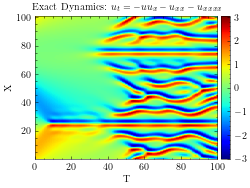

In [14]:
fig, ax = plt.subplots(1, 1)

# Artificial training points
# ax.scatter(X_u_train_np[:, 1:2], X_u_train_np[:, 0:1], 
#            marker='x', color='black')

h = ax.imshow(Exact.T, interpolation='nearest', cmap='jet', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')

ax.set_title("Exact Dynamics: $u_t = -uu_{x}-u_{xx}-u_{xxxx}$", fontsize = 10)
ax.set_xlabel('T')
ax.set_ylabel('X')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

fig.savefig("./vis_pics/Exact_Dynamics.png", dpi=300)
plt.show()

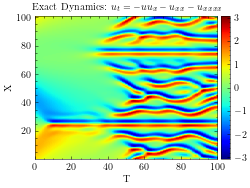

In [15]:
fig, ax = plt.subplots(1, 1)

# Artificial training points
# ax.scatter(X_u_train_np[:, 1:2], X_u_train_np[:, 0:1], 
#            marker='x', color='black')

h = ax.imshow(uf.reshape(X.shape).T, interpolation='nearest', cmap='jet', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')

ax.set_title("Exact Dynamics: $u_t = -uu_{x}-u_{xx}-u_{xxxx}$", fontsize = 10)
ax.set_xlabel('T')
ax.set_ylabel('X')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# fig.savefig("./vis_pics/Exact_Dynamics.png", dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)

# plots filled contour plot
ax.contourf(T[:NUMBER//1024, :], X[:NUMBER//1024, :], Exact[:NUMBER//1024, :])

ax.set_title('Exact')
ax.set_xlabel('T')
ax.set_ylabel('X')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)

# plots filled contour plot
ax.contourf(T[:NUMBER//1024, :], X[:NUMBER//1024, :], uf.reshape(NUMBER//1024, 1024))

ax.set_title('Learned system dynamics')
ax.set_xlabel('T')
ax.set_ylabel('X')

plt.show()

In [ ]:
end = NUMBER//1024 + 3
performances = []
for i in trange(1, end):
    NUMBER = 1024*i # 20000, 21000
    NUMBER = min(NUMBER, X_star.shape[0])
    xx, tt = X_star[:NUMBER, 0:1], X_star[:NUMBER, 1:2]
    uf = pinn(xx, tt).detach().numpy()
    performances.append(mean_squared_error(uf, u_star[:NUMBER].numpy()))

In [ ]:
plt.plot(range(1, end), performances)
plt.show()

In [ ]:
performances

In [ ]:
# save(pinn, "./new_saved_path/KS_rudy_noisy_pretrained_pinn.pth")

#### 2-nd Stage learning

In [ ]:
_, x_fft, x_PSD = fft1d_denoise(X_u_train[:, 0:1], c=-5, return_real=True)
_, t_fft, t_PSD = fft1d_denoise(X_u_train[:, 1:2], c=-5, return_real=True)
_, u_train_fft, u_train_PSD = fft1d_denoise(u_train, c=-5, return_real=True)

In [ ]:
x_fft, x_PSD = x_fft.detach(), x_PSD.detach()
t_fft, t_PSD = t_fft.detach(), t_PSD.detach()

In [ ]:
def closure():
    if torch.is_grad_enabled():
        optimizer2.zero_grad()
    losses = pinn.loss(X_u_train, (x_fft, x_PSD, t_fft, t_PSD), u_train, (u_train_fft, u_train_PSD), update_network_params=True, update_pde_params=True)
    l = sum(losses)
    if l.requires_grad:
        l.backward(retain_graph=True)
    return l

def mtl_closure():
    losses = pinn.loss(X_u_train, (x_fft, x_PSD, t_fft, t_PSD), u_train, (u_train_fft, u_train_PSD), update_network_params=True, update_pde_params=True)
    updated_grads = []
    
    for i in range(len(losses)):
        optimizer1.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in pinn.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(pinn.parameters()): 
        param.grad = updated_grads[0][idx]+updated_grads[1][idx]
        
    return sum(losses)

In [ ]:
# pinn.loss(X_u_train, (x_fft, x_PSD, t_fft, t_PSD), u_train, (u_train_fft, u_train_PSD), update_network_params=True, update_pde_params=True)

In [ ]:
epochs1, epochs2 = 200, 20
# TODO: Save best state dict and training for more epochs.
optimizer1 = MADGRAD(pinn.parameters(), lr=1e-5, momentum=0.9)
pinn.train(); best_train_loss = 1e6

print('1st Phase optimization using Adam with PCGrad gradient modification')
for i in range(epochs1):
    optimizer1.step(mtl_closure)
    if (i % 10) == 0 or i == epochs1-1:
        l = mtl_closure()
        print("Epoch {}: ".format(i), l.item())
        print(pinn.param0, pinn.param1, pinn.param2)
        
optimizer2 = torch.optim.LBFGS(pinn.parameters(), lr=1e-1, max_iter=500, max_eval=int(500*1.25), history_size=300, line_search_fn='strong_wolfe')
print('2nd Phase optimization using LBFGS')
for i in range(epochs2):
    optimizer2.step(closure)
    if (i % 5) == 0 or i == epochs2-1:
        l = closure()
        print("Epoch {}: ".format(i), l.item())

In [ ]:
pred_params = [pinn.param0.item(), pinn.param1.item(), pinn.param2.item()]
print(pred_params)

In [ ]:
errs = 100*np.abs(np.array(pred_params)+1)
print(errs.mean(), errs.std())

In [ ]:
save(pinn, "./new_saved_path/KS_rudy_final_finetuned_no_dft_pinn.pth")

In [ ]:
### New results ###
# finetuned pinn on KS_new.pkl

# w/o DFT
# clean all
# [-1.0038105249404907, -1.0389138460159302, -1.018654465675354]
# 2.0459612210591636 1.4387603533171842

# w/o DFT
# clean (x, t) and noisy lables
# 1st run
# [-0.9552096724510193, -1.0218358039855957, -1.0091873407363892]
# 2.527115742365519 1.4736449310642017
# 2nd run
# [-0.9824689626693726, -1.0259006023406982, -1.0224767923355103]
# 2.1969477335611978 0.34356397750920376

# w/o DFT
# noisy (x, t) and noisy lables
# [-0.9445462822914124, -1.0215760469436646, -1.0037590265274048]
# 2.692959705988566 2.1441092139699642

###############################
# w/ DFT
# clean all
# [-0.9454907774925232, -1.0266990661621094, -1.0051020383834839]
# 2.8770109017690024 2.0223490873202765

# w/ DFT
# clean (x, t) and noisy lables
# [-0.965919554233551, -1.0234534740447998, -1.0168591737747192]
# 2.479769786198934 0.7094516920660559

# w/ DFT
# noisy (x, t) and noisy lables
# [-0.9662449955940247, -1.0259292125701904, -1.0150245428085327]
# 2.4902919928232827 0.7681037488669546

In [ ]:
### New results ###

# w/o DFT
# noisy labels
# [-0.9948846697807312, -1.0065652132034302, -0.9950999617576599]
# 0.5526860555013021 0.07394681988603513

# noisy (x, t) and labels
# [-0.9892916083335876, -1.011358618736267, -0.9886858463287354]
# 1.1127054691314697 0.029659549537678777

# /w DFT
# clean | /w DFT
# [-0.9948897361755371, -1.0049610137939453, -0.9951441287994385]
# 0.4975716272989909 0.01043744028051521

# noisy (x, t) and labels | /w DFT
# [-0.9947568774223328, -1.0052711963653564, -0.9935149550437927]
# 0.5666454633076986 0.05789442242742208

In [ ]:
### Without AutoEncoder ###

# Clean Exact and (x, t)
# [-0.999634325504303, -0.9994997382164001, -0.9995566010475159]
# (0.04364450772603353, 0.005516461306387781)

# Pretrained with final_finetuned_pinn_5000 (do not use / report)
# [-0.9996052980422974, -0.9995099902153015, -0.9995319247245789]
# 0.04509290059407552 0.0040754479422416435

# Noisy Exact and clean (x, t)
# [-0.9967969655990601, -0.9969800114631653, -0.9973703026771545]
# (0.2950906753540039, 0.023910676954986623)

# Noisy Exact and noisy (x, t)
# [-0.9975059032440186, -0.9962050914764404, -0.9969104528427124]
# 0.3126184145609538 0.05316856937153804

In [ ]:
### Without AutoEncoder & With Robust PCA ###

# Noisy Exact and clean (x, t)
# [-1.0003160238265991, -1.0005097389221191, -0.9997726678848267]
# (0.035103162129720054, 0.011791963483533422)

# Noisy Exact and noisy (x, t) + Robust PCA
# [-1.000351071357727, -0.9991073608398438, -0.9980993866920471]
# (0.08140603701273601 0.09209241474722876)

In [ ]:
### Without AutoEncoder & With Double Beta-Robust PCA ###

# Noisy Exact and clean (x, t)
# [-1.0013889074325562, -0.998389720916748, -1.0010501146316528]
# 0.1349767049153646 0.023035484282371465

# Noisy Exact and noisy (x, t) + Robust PCA
# [-0.9980248212814331, -0.9982557892799377, -0.998869001865387]
# 0.1616795857747396 0.03562172791384541